**LSTM without new**

In [ ]:

import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=1
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("/content/hnxindex.csv")
cols = ['Adj Close']

len_dataframe=dataframe.shape[0]

In [ ]:
# Loại bỏ các hàng chứa NaN
dataframe = dataframe.dropna()

# Hoặc nếu bạn muốn loại bỏ các cột chứa NaN:
dataframe = dataframe.dropna(axis=1)

# Lưu lại file CSV sau khi loại bỏ NaN
dataframe.to_csv("/content/hnxindex_cleaned.csv", index=False)

# Kiểm tra lại dữ liệu sau khi loại bỏ NaN
print(dataframe.head())

       Date  Adj Close  cafef_mean_compound  vietstock_mean_compound  \
0  2/1/2024     229.99             0.212000                  0.12440   
1  3/1/2024     231.64             0.000000                 -0.13660   
2  4/1/2024     232.56             0.074667                  0.15910   
3  5/1/2024     232.76             0.435667                 -0.15910   
4  8/1/2024     233.33            -0.167433                  0.62885   

   economy_mean_compound  ktck_mean_compound  
0               0.098667            0.148000  
1               0.403300            0.064125  
2               0.230825            0.083733  
3               0.217200           -0.120400  
4               0.415650            0.058475  


In [ ]:
dataframe = pd.read_csv("/content/hnxindex_cleaned.csv")

In [ ]:
print(dataframe.columns)


Index(['Date', 'Adj Close', 'cafef_mean_compound', 'vietstock_mean_compound',
       'economy_mean_compound', 'ktck_mean_compound'],
      dtype='object')


In [ ]:
i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)

data_train.shape (120, 1)
data_test.shape (22, 1)


In [ ]:
#get_test_data
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

y_test_ori.shape (12, 1)


In [ ]:
#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)


In [ ]:
# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)


x_test.shape (12, 9, 1)
y_test.shape (12, 1)


In [ ]:
#get_train_data
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)


In [ ]:
# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)


x_train.shape (110, 9, 1)
y_train.shape (110, 1)


In [ ]:
import numpy as np
print(np.isnan(x_train).sum(), np.isinf(x_train).sum())
print(np.isnan(y_train).sum(), np.isinf(y_train).sum())


0 0
0 0


In [ ]:
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)

In [ ]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.5174
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4394 
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3673 
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2826
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2357


In [ ]:
import numpy as np
print(np.isnan(x_test).sum(), np.isinf(x_test).sum())
print(np.isnan(y_test).sum(), np.isinf(y_test).sum())

0 0
0 0


In [ ]:
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

In [ ]:
model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


array([[0.49359983],
       [0.5287219 ],
       [0.66008246],
       [0.73144317],
       [0.7980365 ],
       [0.85471237],
       [0.87026393],
       [0.8374287 ],
       [0.7973532 ],
       [0.73007   ],
       [0.64534354],
       [0.6417738 ]], dtype=float32)

In [ ]:
#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)

print(prediction_seqs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[array([0.49359983], dtype=float32)], [array([0.52872187], dtype=float32)], [array([0.6600826], dtype=float32)], [array([0.7314432], dtype=float32)], [array([0.7980365], dtype=float32)], [array([0.8547124], dtype=float32)], [array([0.87026393], dtype=float32)], [array([0.83742857], dtype=float32)], [array([0.7973534], dtype=float32)], [array([0.73007], dtype=float32)], [array([0.6453436], dtype=float32)], [array([0.6417738], dtype=float32)]]


In [ ]:
#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)



[243.19889518380165, 243.66649350583555, 244.04199307441712, 244.38166975736618, 244.62190769076346, 244.6023064661026, 243.99014784932135, 243.635854268074, 242.90842229127884, 242.12702164769172, 241.25349253356455, 239.66359543919563]


In [ ]:
error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])

squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)

MSE [27.83473]
accuracy [0.98042697]
mean_error_percent [0.01957303]


In [ ]:
print(abs(y_test_ori -de_predicted)/y_test_ori)

[[0.0059408  0.00530031 0.0066227  0.0063205  0.0068646  0.01056064
  0.01864962 0.01870426 0.01998255 0.01988762 0.02063654 0.02665353]
 [0.00622493 0.00558461 0.00690663 0.00660451 0.00714845 0.01084344
  0.01893011 0.01898474 0.02026266 0.02016775 0.02091646 0.02693173]
 [0.01031737 0.01096834 0.00962432 0.00993146 0.00937847 0.00562197
  0.00259931 0.00265484 0.00395404 0.00385755 0.00461872 0.01073412]
 [0.00369274 0.00433945 0.00300424 0.00330937 0.00276    0.00097186
  0.00913924 0.00919441 0.01048508 0.01038923 0.01114541 0.01722071]
 [0.01191358 0.01256558 0.01121943 0.01152706 0.01097319 0.00721077
  0.00102351 0.00107913 0.00238038 0.00228373 0.00304611 0.00917117]
 [0.02099779 0.02165564 0.02029742 0.02060781 0.02004897 0.01625276
  0.00794457 0.00788845 0.00657552 0.00667303 0.00590381 0.00027624]
 [0.03744865 0.0381171  0.03673699 0.03705238 0.03648454 0.03262717
  0.02418511 0.02412808 0.022794   0.02289308 0.02211147 0.01583184]
 [0.03055195 0.03121596 0.02984502 0.0301

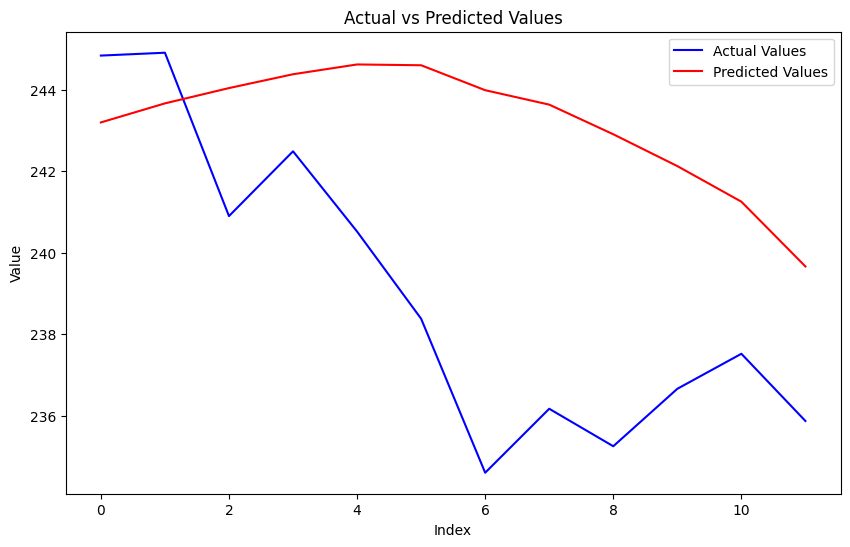

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ y_test_ori (giá trị thực tế)
plt.plot(y_test_ori, label='Actual Values', color='blue')

# Vẽ de_predicted (giá trị dự đoán)
plt.plot(de_predicted, label='Predicted Values', color='red')

# Thêm tiêu đề và nhãn cho các trục
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


In [ ]:
de_predicted1=de_predicted
de_predicted1

[243.19889518380165,
 243.66649350583555,
 244.04199307441712,
 244.38166975736618,
 244.62190769076346,
 244.6023064661026,
 243.99014784932135,
 243.635854268074,
 242.90842229127884,
 242.12702164769172,
 241.25349253356455,
 239.66359543919563]

In [ ]:
def calculate_MPA(actual_values, predicted_values):
    # Chắc chắn rằng actual_values và predicted_values có cùng kích thước
    assert len(actual_values) == len(predicted_values), "Actual and predicted arrays must have the same length"

    # Tính toán MPA
    N = len(actual_values)
    sum_abs_error = np.sum(np.abs(actual_values - predicted_values) / actual_values)
    MPA = 1 - (sum_abs_error / N)

    return MPA

In [ ]:
calculate_MPA(y_test_ori,de_predicted1)

0.7560177054604037

**LSTM with new**

In [ ]:
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM, Input
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


split = (0.85);
sequence_length=10;
normalise= True
batch_size=100;
input_dim=5
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0

dataframe = pd.read_csv("/content/hnxindex_cleaned.csv")
print(dataframe.columns)

Index(['Date', 'Adj Close', 'cafef_mean_compound', 'vietstock_mean_compound',
       'economy_mean_compound', 'ktck_mean_compound'],
      dtype='object')


In [ ]:
cols = ['Adj Close','cafef_mean_compound',
       'vietstock_mean_compound', 'economy_mean_compound',
       'ktck_mean_compound']

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_train = dataframe.get(cols).values[:i_split]
data_test  = dataframe.get(cols).values[i_split:]
len_train  = len(data_train)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_test.shape',data_test.shape)


data_train.shape (120, 5)
data_test.shape (22, 5)


In [ ]:

data_train[0:5]

array([[ 2.29990000e+02,  2.12000000e-01,  1.24400000e-01,
         9.86666670e-02,  1.48000000e-01],
       [ 2.31640000e+02,  0.00000000e+00, -1.36600000e-01,
         4.03300000e-01,  6.41250000e-02],
       [ 2.32560000e+02,  7.46666670e-02,  1.59100000e-01,
         2.30825000e-01,  8.37333330e-02],
       [ 2.32760000e+02,  4.35666667e-01, -1.59100000e-01,
         2.17200000e-01, -1.20400000e-01],
       [ 2.33330000e+02, -1.67433333e-01,  6.28850000e-01,
         4.15650000e-01,  5.84750000e-02]])

In [ ]:
data_test[0:5]

array([[ 2.40800000e+02,  1.48000000e-01,  2.91866667e-01,
         2.86000000e-02,  8.44200000e-01],
       [ 2.41430000e+02,  5.26700000e-01,  1.06066667e-01,
        -8.50333330e-02,  2.36700000e-01],
       [ 2.41880000e+02,  0.00000000e+00, -2.55500000e-02,
         1.61600000e-01,  2.12000000e-01],
       [ 2.42310000e+02,  0.00000000e+00,  2.25933333e-01,
         3.74333333e-01, -8.60000000e-03],
       [ 2.43150000e+02,  0.00000000e+00, -1.46666670e-02,
         1.80800000e-01,  2.32633333e-01]])

In [ ]:
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
 # get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

y_test_ori.shape (12, 1)


In [ ]:
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

In [ ]:
#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

x_test.shape (12, 9, 5)
y_test.shape (12, 1)


In [ ]:
x_test[0]

array([[ 0.        ,  0.148     ,  0.29186667,  0.0286    ,  0.8442    ],
       [ 0.12962963,  0.5267    ,  0.10606667, -0.08503333,  0.2367    ],
       [ 0.22222222,  0.        , -0.02555   ,  0.1616    ,  0.212     ],
       [ 0.31069959,  0.        ,  0.22593333,  0.37433333, -0.0086    ],
       [ 0.48353909,  0.        , -0.01466667,  0.1808    ,  0.23263333],
       [ 1.        ,  0.4144    ,  0.4378    ,  0.26013333, -0.21823333],
       [ 0.76954733,  0.2294    , -0.0334    ,  0.0911    ,  0.148     ],
       [ 0.94444444,  0.2997    , -0.17      ,  0.17963333,  0.2027    ],
       [ 0.86831276,  0.25825   , -0.1591    , -0.2276    , -0.0593    ]])

In [ ]:
y_test

array([[0.83127572],
       [0.82269504],
       [0.        ],
       [0.33403361],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.1455051 ],
       [0.06238004],
       [0.19980601],
       [0.28322017],
       [0.16096324]])

In [ ]:
#get_train_data
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)

x_train.shape (110, 9, 5)
y_train.shape (110, 1)


In [ ]:
x_train[0]

array([[ 0.42214533,  0.212     ,  0.1244    ,  0.09866667,  0.148     ],
       [ 0.70761246,  0.        , -0.1366    ,  0.4033    ,  0.064125  ],
       [ 0.86678201,  0.07466667,  0.1591    ,  0.230825  ,  0.08373333],
       [ 0.90138408,  0.43566667, -0.1591    ,  0.2172    , -0.1204    ],
       [ 1.        , -0.16743333,  0.62885   ,  0.41565   ,  0.058475  ],
       [ 0.85640138,  0.29086667,  0.        ,  0.2884    ,  0.        ],
       [ 0.66782007,  0.53505   ,  0.        ,  0.35775   ,  0.06906667],
       [ 0.89273356,  0.3803    ,  0.2787    ,  0.2971    , -0.33525   ],
       [ 0.47750865,  0.26026667, -0.06005   ,  0.318     ,  0.2732    ]])

In [ ]:
y_train[0:5]

array([[0.        ],
       [0.33737024],
       [0.33737024],
       [0.41176471],
       [0.33391003]])

In [ ]:
import numpy as np
print(np.isnan(x_train).sum(), np.isinf(x_train).sum())
print(np.isnan(y_train).sum(), np.isinf(y_train).sum())
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)

0 0
0 0


In [ ]:
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)


In [ ]:
import numpy as np
print(np.isnan(x_test).sum(), np.isinf(x_test).sum())
print(np.isnan(y_test).sum(), np.isinf(y_test).sum())
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

0 0
0 0


In [ ]:
# LSTM MODEL
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
model = Sequential()
model.add(Input(shape=(input_timesteps, input_dim)))
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.5119
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4198
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3213
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2515
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1963


In [ ]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)


model.predict(x_test)


#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)

print(prediction_seqs)


#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)

error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])

squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.5175
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4476 
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3729
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2976
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2241
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[array([0.4945931], dtype=float32)], [array([0.4978602], dtype=float32)], [array([0.5677401], dtype=float32)], [array([0.6245404], dtype=float32)], [array([0.68022066], dtype=float32)], [

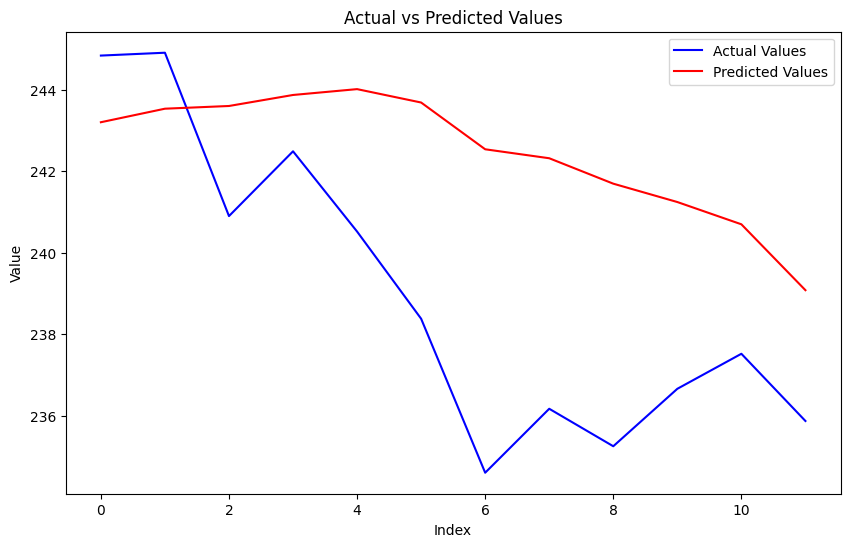

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ y_test_ori (giá trị thực tế)
plt.plot(y_test_ori, label='Actual Values', color='blue')

# Vẽ de_predicted (giá trị dự đoán)
plt.plot(de_predicted, label='Predicted Values', color='red')

# Thêm tiêu đề và nhãn cho các trục
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


In [ ]:
de_predicted2=de_predicted
de_predicted2

[243.20372253239157,
 243.53594861745836,
 243.60244279384614,
 243.87281224966048,
 244.01633421063423,
 243.68750381946563,
 242.53969712197778,
 242.319626917243,
 241.6954063129425,
 241.24484003722668,
 240.69814483821392,
 239.08085281848906]

**DP-LSTM**

In [ ]:
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats


df = pd.read_csv("/content/hnxindex_cleaned.csv")

cafef_var=np.var(df.cafef_mean_compound)
vietstock_var=np.var(df.vietstock_mean_compound)
economy_var=np.var(df.economy_mean_compound)
ktck_var=np.var(df.ktck_mean_compound)

mu=0

noise=0.1

sigma_cafef=noise*cafef_var
sigma_vietstock=noise*vietstock_var
sigma_economy=noise*economy_var
sigma_ktck=noise*ktck_var

n=df.shape[0]

df_noise=pd.DataFrame()

df_noise['cafef_noise']=df['cafef_mean_compound']
df_noise['vietstock_noise']=df['vietstock_mean_compound']
df_noise['economy_noise']=df['economy_mean_compound']
df_noise['ktck_noise']=df['ktck_mean_compound']

for i in range(0,n):
    df_noise['cafef_noise'][i]+=np.random.normal(mu,sigma_cafef)
    df_noise['vietstock_noise'][i]+=np.random.normal(mu,sigma_vietstock)
    df_noise['economy_noise'][i]+=np.random.normal(mu,sigma_economy)
    df_noise['ktck_noise'][i]+=np.random.normal(mu,sigma_ktck)


df_noise.to_csv("/content/source_price_noise0.csv")
dfn=pd.read_csv("/content/source_price_noise0.csv",index_col=0)

In [ ]:
df_1n=pd.DataFrame()
df_1n['cafef']=df_noise['cafef_noise']
df_1n['vietstock']=df['vietstock_mean_compound']
df_1n['economy']=df['economy_mean_compound']
df_1n['ktck']=df['ktck_mean_compound']
df_1n['price']=df['Adj Close']

df_2n=pd.DataFrame()
df_2n['cafef']=df['cafef_mean_compound']
df_2n['vietstock']=df_noise['vietstock_noise']
df_2n['economy']=df['economy_mean_compound']
df_2n['ktck']=df['ktck_mean_compound']
df_2n['price']=df['Adj Close']

df_3n=pd.DataFrame()
df_3n['cafef']=df['cafef_mean_compound']
df_3n['vietstock']=df['vietstock_mean_compound']
df_3n['economy']=df_noise['economy_noise']
df_3n['ktck']=df['ktck_mean_compound']
df_3n['price']=df['Adj Close']

df_4n=pd.DataFrame()
df_4n['cafef']=df['cafef_mean_compound']
df_4n['vietstock']=df['vietstock_mean_compound']
df_4n['economy']=df['economy_mean_compound']
df_4n['ktck']=df_noise['ktck_noise']
df_4n['price']=df['Adj Close']

df1=df_1n
df2=df_2n
df3=df_3n
df4=df_4n

In [ ]:

split = (0.85)
sequence_length=10;
normalise= True
batch_size=100;
input_dim=5
input_timesteps=9
neurons=50
epochs=5
prediction_len=1
dense_output=1
drop_out=0



i_split = int(len(df1) * split)

cols = ['price','cafef','vietstock','economy','ktck']
data_train_1 = df1.get(cols).values[:i_split]
data_train_2 = df2.get(cols).values[:i_split]
data_train_3 = df3.get(cols).values[:i_split]
data_train_4 = df4.get(cols).values[:i_split]

len_train  = len(data_train_1)
len_train_windows = None



#get_train_data
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train_1[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
record_min=[]
record_max=[]

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train1 = data_windows[:, :-1]
y_train1 = data_windows[:, -1,[0]]
print('x_train1.shape',x_train1.shape)
print('y_train1.shape',y_train1.shape)


x_train1.shape (110, 9, 5)
y_train1.shape (110, 1)


In [ ]:
#get_train_data
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train_2[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
record_min=[]
record_max=[]

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train2 = data_windows[:, :-1]
y_train2 = data_windows[:, -1,[0]]
print('x_train2.shape',x_train2.shape)
print('y_train2.shape',y_train2.shape)


x_train2.shape (110, 9, 5)
y_train2.shape (110, 1)


In [ ]:
#get_train_data
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train_3[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
record_min=[]
record_max=[]

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train3 = data_windows[:, :-1]
y_train3 = data_windows[:, -1,[0]]
print('x_train3.shape',x_train3.shape)
print('y_train3.shape',y_train3.shape)

x_train3.shape (110, 9, 5)
y_train3.shape (110, 1)


In [ ]:

#get_train_data

data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train_4[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
record_min=[]
record_max=[]

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data
x_train4 = data_windows[:, :-1]
y_train4 = data_windows[:, -1,[0]]
print('x_train4.shape',x_train4.shape)
print('y_train4.shape',y_train4.shape)

x_train4.shape (110, 9, 5)
y_train4.shape (110, 1)


In [ ]:

##concat train window
type(x_train4)


numpy.ndarray

In [ ]:

x_train_t=np.concatenate((x_train1,x_train2,x_train3,x_train4),axis=0)
print(x_train_t.shape)
x_train=x_train_t

y_train_t=np.concatenate((y_train1,y_train2,y_train3,y_train4),axis=0)
print(y_train_t.shape)
y_train=y_train_t


(440, 9, 5)
(440, 1)


In [ ]:
dataframe = pd.read_csv("/content/hnxindex_cleaned.csv")
print(dataframe.columns)  # Check the actual number of columns

Index(['Date', 'Adj Close', 'cafef_mean_compound', 'vietstock_mean_compound',
       'economy_mean_compound', 'ktck_mean_compound'],
      dtype='object')


In [ ]:
dataframe= pd.read_csv("/content/hnxindex_cleaned.csv")
dataframe.columns=[ 'Date', 'Adj Close', 'cafef_mean_compound',
       'vietstock_mean_compound', 'economy_mean_compound',
       'ktck_mean_compound']
cols = ['Adj Close', 'cafef_mean_compound',
       'vietstock_mean_compound', 'economy_mean_compound',
       'ktck_mean_compound']
len_dataframe=dataframe.shape[0]

In [ ]:

len_dataframe=dataframe.shape[0]

i_split = int(len(dataframe) * split)
data_test  = dataframe.get(cols).values[i_split:]

len_test   = len(data_test)
len_train_windows = None

print('data_test.shape',data_test.shape)

data_test.shape (22, 5)


In [ ]:
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])

data_windows = np.array(data_windows).astype(float)

y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)


y_test_ori.shape (12, 1)


In [ ]:
y_test_ori

array([[244.84],
       [244.91],
       [240.9 ],
       [242.49],
       [240.52],
       [238.38],
       [234.6 ],
       [236.17],
       [235.25],
       [236.66],
       [237.52],
       [235.87]])

In [ ]:
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

#normalize
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

# normalised_data=window_data
data_windows=normalised_data#get_test_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)


x_test.shape (12, 9, 5)
y_test.shape (12, 1)


In [ ]:
import numpy as np
print(np.isnan(x_train).sum(), np.isinf(x_train).sum())
print(np.isnan(y_train).sum(), np.isinf(y_train).sum())

0 0
0 0


In [ ]:
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)

In [ ]:
import numpy as np
print(np.isnan(x_test).sum(), np.isinf(x_test).sum())
print(np.isnan(y_test).sum(), np.isinf(y_test).sum())

0 0
0 0


In [ ]:
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

In [ ]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
model.add(Dropout(drop_out))
model.add(LSTM(neurons,return_sequences = True))
model.add(LSTM(neurons,return_sequences =False))
model.add(Dropout(drop_out))
model.add(Dense(dense_output, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error',
                optimizer='adam')
# Fit the model
model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.5102
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2916
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1829
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1877
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1558


In [ ]:
#multi sequence predict
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:

#de_predicted
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)

[243.3854533994198, 243.5422723570466, 243.21849828362465, 243.2924887037277, 243.15927253365518, 242.25433340072632, 240.27382629454135, 240.260448461771, 239.94747179865837, 239.97071632027627, 239.78734976649284, 238.31414957642556]


In [ ]:
de_predicted3=de_predicted
de_predicted3

[243.3854533994198,
 243.5422723570466,
 243.21849828362465,
 243.2924887037277,
 243.15927253365518,
 242.25433340072632,
 240.27382629454135,
 240.260448461771,
 239.94747179865837,
 239.97071632027627,
 239.78734976649284,
 238.31414957642556]

In [ ]:
 np.save('/content/sp_5dim_n01_7033.npy',de_predicted)

In [ ]:
error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])

squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)
print('mean_error_percent',mean_error_percent)



MSE [10.42066045]
accuracy [0.98774536]
mean_error_percent [0.01225464]


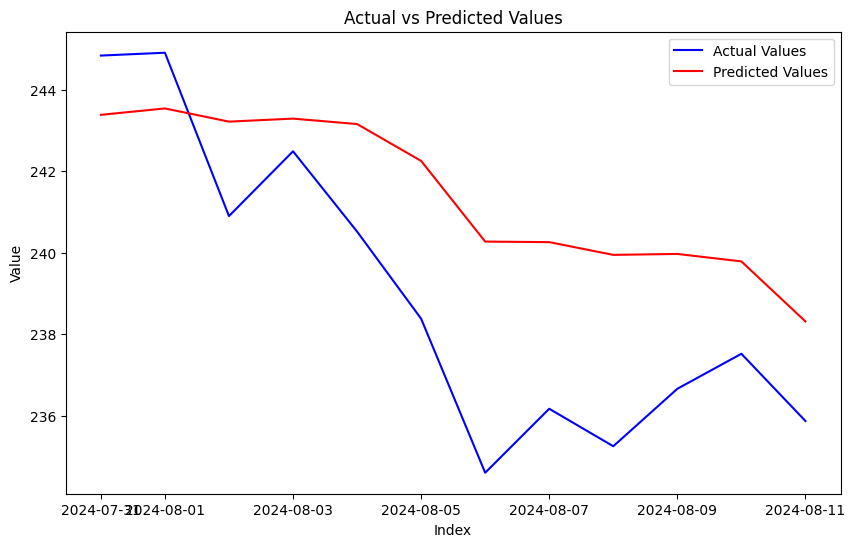

In [ ]:
import matplotlib.pyplot as plt
dates = pd.date_range(start='31/7/2024', periods=len(y_test_ori), freq='D')
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ y_test_ori (giá trị thực tế)
plt.plot(dates, y_test_ori, label='Actual Values', color='blue')

# Vẽ de_predicted (giá trị dự đoán)
plt.plot(dates, de_predicted, label='Predicted Values', color='red')

# Thêm tiêu đề và nhãn cho các trục
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


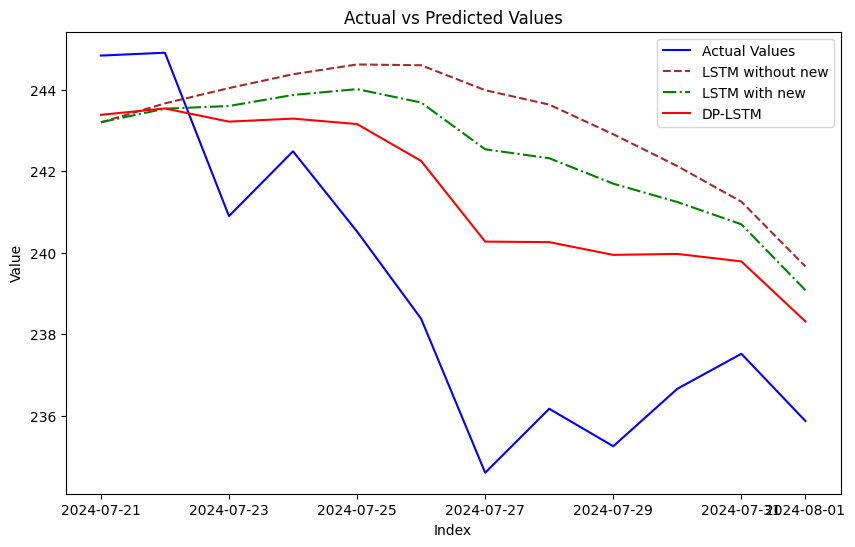

In [ ]:
import matplotlib.pyplot as plt
dates = pd.date_range(start='21-7-2024', periods=len(y_test_ori), freq='D')
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ y_test_ori (giá trị thực tế)
plt.plot(dates,y_test_ori, label='Actual Values', color='blue')

#Vẽ de_predicted1 (giá trị dự đoán của LSTM)
plt.plot(dates,de_predicted1, label='LSTM without new', color='brown', linestyle='--')
#Vẽ de_predicted2 (giá trị dự đoán của LSTM without new)
plt.plot(dates,de_predicted2, label='LSTM with new', color='green',  linestyle='dashdot')
#Vẽ de_predicted3 (giá trị dự đoán của DP-LSTM)
plt.plot(dates,de_predicted3, label='DP-LSTM', color='red')
# Thêm tiêu đề và nhãn cho các trục
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


In [ ]:
calculate_MPA(y_test_ori,de_predicted1)



0.7560177054604037

In [ ]:
calculate_MPA(y_test_ori,de_predicted2)

0.7772865214094752

In [ ]:
calculate_MPA(y_test_ori,de_predicted3)

0.7995451277133806